# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sn

# Getting our datasets

In [2]:
image_size = (224, 224)
batch_size = 32

In [3]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2185 files belonging to 15 classes.


In [4]:
val = tf.keras.preprocessing.image_dataset_from_directory(
    "data/valid",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 75 files belonging to 15 classes.


# Data Augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomContrast(0.5),
        layers.RandomZoom(0.3)
    ]
)

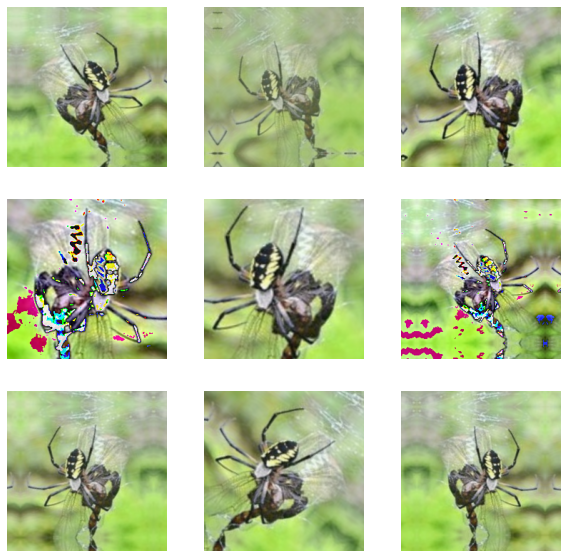

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Model

First we will get our MobileNetV2 model and use as a base.

## MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=image_size + (3,),
    include_top=False,
    weights='imagenet')

In [8]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [9]:
base_model.trainable = False

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [11]:
prediction_layer = tf.keras.layers.Dense(15,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 15)


In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
inputs = tf.keras.Input(shape=image_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(15)(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
loss0, accuracy0 = model.evaluate(val)

3/3 [==============================] - 4s 602ms/step - loss: 2.8173 - accuracy: 0.1333


In [17]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.82
initial accuracy: 0.13


# Training

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler 
EarlyStop_callback = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

In [19]:
history = model.fit(train,
                    epochs=10,
                    validation_data=val,
                   callbacks = [EarlyStop_callback])

Epoch 1/10
69/69 [==============================] - 95s 1s/step - loss: 2.4705 - accuracy: 0.2394 - val_loss: 1.2706 - val_accuracy: 0.7733
Epoch 2/10
69/69 [==============================] - 96s 1s/step - loss: 1.6162 - accuracy: 0.4833 - val_loss: 0.7693 - val_accuracy: 0.8267
Epoch 3/10
69/69 [==============================] - 92s 1s/step - loss: 1.2443 - accuracy: 0.5986 - val_loss: 0.5882 - val_accuracy: 0.8533
Epoch 4/10
69/69 [==============================] - 90s 1s/step - loss: 1.0612 - accuracy: 0.6499 - val_loss: 0.4823 - val_accuracy: 0.8933
Epoch 5/10
69/69 [==============================] - 88s 1s/step - loss: 0.9417 - accuracy: 0.6828 - val_loss: 0.4262 - val_accuracy: 0.9200
Epoch 6/10
69/69 [==============================] - 95s 1s/step - loss: 0.8594 - accuracy: 0.7062 - val_loss: 0.3770 - val_accuracy: 0.9067
Epoch 7/10
69/69 [==============================] - 95s 1s/step - loss: 0.7951 - accuracy: 0.7208 - val_loss: 0.3533 - val_accuracy: 0.9200
Epoch 8/10
69/69 [==

# Results

In [20]:
img = keras.preprocessing.image.load_img(
    "data/test/Ladybird Mimic Spider/1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
score

array([-1.8423487 , -3.0923922 , -1.0962901 , -1.4576695 , -1.0883121 ,
       -1.9414035 , -2.912745  , -2.7138965 ,  1.6619742 , 10.1441    ,
        1.7270544 , -2.2007527 ,  1.3108258 , -2.5653927 , -0.34170356],
      dtype=float32)

In [21]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test",
    seed=1337,
    image_size=image_size)

class_names = [
    'Black Widow',
    'Blue Tarantula',
    'Bold Jumper',
    'Brown Grass Spider',
    'Brown Recluse Spider',
    'Deinopis Spider',
    'Golden Orb Weaver',
    'Hobo Spider',
    'Huntsman Spider',
    'Ladybird Mimic Spider',
    'Peacock Spider',
    'Red Knee Tarantula',
    'Spiny-backed Orb-weaver',
    'White Kneed Tarantula',
    'Yellow Garden Spider'
]

Found 75 files belonging to 15 classes.


In [22]:
predictions = []
image_ids = []
for image_batch, label_batch in test:
    batch_predictions = model.predict_on_batch(image_batch)
    batch_predictions = tf.nn.softmax(batch_predictions)
    batch_predictions = batch_predictions.numpy()
    
    class_indices = np.argmax(batch_predictions, axis = 1)
    predicted_class = []
    for index in class_indices:
        predicted_class.append(str(class_names[index]))
    predictions += predicted_class
    
    str_img_ids = []
    for img_id in label_batch:
        str_img_ids.append(class_names[img_id])
    
#     image_ids += label_batch.numpy().tolist()
    image_ids += str_img_ids

In [23]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
results = pd.DataFrame({'actual': image_ids, 'prediction': predictions})
results

,actual,prediction
0,Ladybird Mimic Spider,Ladybird Mimic Spider
1,Hobo Spider,Hobo Spider
2,Hobo Spider,Hobo Spider
3,Golden Orb Weaver,Golden Orb Weaver
4,Brown Grass Spider,Brown Grass Spider
5,Peacock Spider,Peacock Spider
6,Huntsman Spider,Huntsman Spider
7,Black Widow,Black Widow
8,Deinopis Spider,Deinopis Spider
9,Blue Tarantula,Blue Tarantula


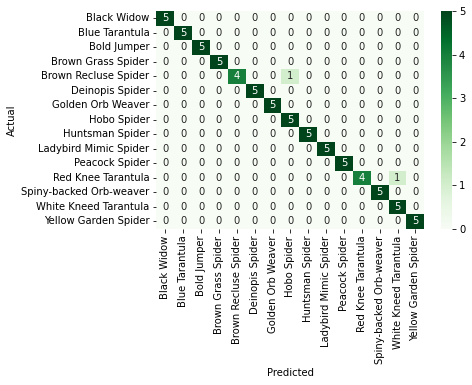

In [25]:
df = pd.DataFrame(results, columns=['actual','prediction'])
confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True, cmap='Greens')
plt.show()

# Credits

Our work is based on these authors:
https://keras.io/examples/vision/image_classification_from_scratch/
https://www.kaggle.com/pranjalkumarnandi/baseline-with-keras-tf/data
https://www.kaggle.com/enesaltun/spiders-resnet18
https://www.kaggle.com/gpiosenka/inceptionresnetv2-98-acc